In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/58/j89y2_691mz0dzk3rc7p_08h0000gp/T/ipykernel_41783/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
for column in measurements.__table__.columns:
    print(column.name)

id
station
date
prcp
tobs


In [10]:
#looking at a sample of the data
sample = session.query(measurements.id, measurements.station, measurements.date, measurements.prcp, measurements.tobs).first()
sample

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)

In [11]:
# Find the most recent date in the data set.
session.query(measurements.date).order_by(measurements.date.desc()).first()

('2017-08-23',)

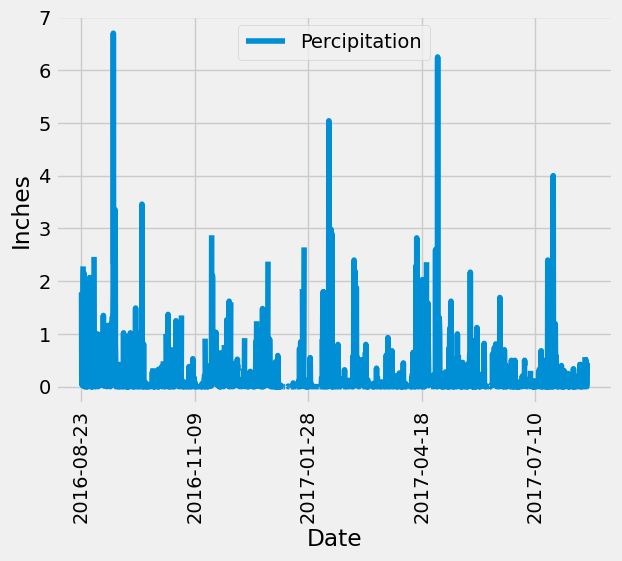

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(measurements.date).order_by(measurements.date.desc()).first()
# most_recent
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
# year_ago
# Perform a query to retrieve the data and precipitation scores
last_year = session.query(measurements.date, measurements.prcp).filter(measurements.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_year, columns=['Date', 'Percipitation'])

# Sort the dataframe by date
df.set_index('Date', inplace=True)
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(ylabel = "Inches")
plt.xticks(rotation = 90)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()


,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
all_stations = session.query(stations).count()
all_stations

9

In [15]:
for column in stations.__table__.columns:
    print(column.name)

id
station
name
latitude
longitude
elevation


In [16]:
#looking at a sample of the data
sample = session.query(stations.id, stations.station, stations.name, stations.latitude, stations.longitude, stations.elevation).first()
sample

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)

In [17]:
total_rows = session.query(func.count()).select_from(stations).scalar()
total_rows

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
all_stations = session.query(measurements.station, func.count(measurements.station)).group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
all_stations

all_stations                           

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).filter(measurements.station == all_stations[0][0]).all()
most_active

[(54.0, 85.0, 71.66378066378067)]

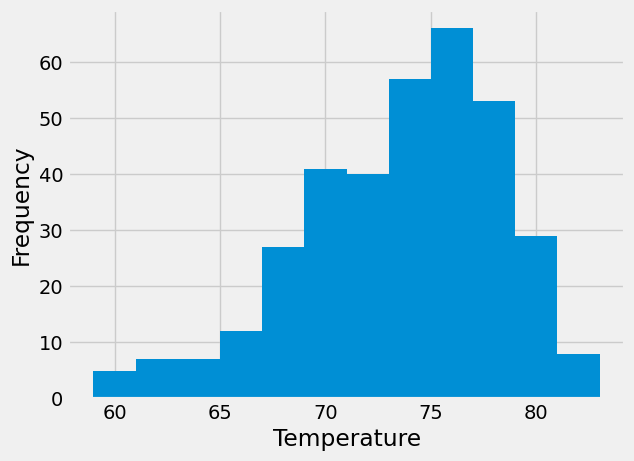

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_recent = session.query(measurements.date).order_by(measurements.date.desc()).first()
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
last_year = session.query(measurements.station, measurements.tobs).filter(measurements.date >= year_ago).filter(measurements.station == all_stations[0][0]).all()

df2 = pd.DataFrame(last_year, columns=['Station', 'Temperature'])

plt.hist(df2["Temperature"], bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



# Close Session

In [21]:
# Close Session
session.close()